In [1]:
__dataset_root_repo = '/data/pcqm4mv2_datahub/datasets/2d_kpgt/'  # the kpgt content is there too
__codes_repo = '/home/shayan/phoenix/graphite/'
__conformers_filepath = '/data/pcqm4mv2_datahub/conformers/conformerpool_10conf_100iter_energymin.np'
import time
import torch
import torch.nn
import sys
sys.path.insert(0, __codes_repo)
from tqdm import tqdm
from torch_geometric.utils import degree
from torch.utils.data.dataloader import DataLoader
from torch_geometric.loader.dataloader import Collater
from graphite.data.pcqm4mv2.pyg import PCQM4Mv2DatasetFull
from graphite.data.pcqm4mv2.pyg.collator import collate_fn, default_collate_fn
from graphite.data.utilities.sequence_collate.utilities import pad_sequence, pad_sequence_2d
from graphite.data.pcqm4mv2.pyg.transforms import ComenetEdgeFeatures, LineGraphTransform
from torchvision.transforms import Compose
from graphite.cortex.model.model.gnn import CoAtGINGeneralPipeline
from graphite.utilities.miscellaneous import count_parameters
from torch_geometric.utils import to_networkx
from networkx.drawing.nx_pylab import draw_networkx
def visualize_graph(g, line_graph: bool = False):
    if line_graph:
        g_nx = to_networkx(g, node_attrs=['x'], edge_attrs=[], graph_attrs=['fingerprint', 'molecule_descriptor'])
    else:
        g_nx = to_networkx(g, node_attrs=['x', 'positions_3d'], edge_attrs=['edge_attr'], graph_attrs=['fingerprint', 'molecule_descriptor'])
        
    draw_networkx(g_nx)

In [2]:
%%time
dataset = PCQM4Mv2DatasetFull(
    root=__dataset_root_repo,
    descriptor=True,
    fingerprint=True,
    conformers_memmap=__conformers_filepath,
    conformer_pool_size=1,
    transform=Compose([
        ComenetEdgeFeatures(cutoff=3.0, edge_index_key='edge_index', concatenate_with_edge_attr=True)
    ]),
)

CPU times: user 1.27 s, sys: 6.35 s, total: 7.62 s
Wall time: 7.64 s


In [3]:
def collate_fn(batch):
    fingerprint = torch.stack([g.fingerprint for g in batch])
    molecule_descriptor = torch.stack([g.molecule_descriptor for g in batch])
    
    g = default_collate_fn(batch)
    del g.fingerprint
    del g.molecule_descriptor
    g.fingerprint = fingerprint
    g.molecule_descriptor = molecule_descriptor[:, 1:]
    return g

In [4]:
split_idx = dataset.get_idx_split()
train_dataset = dataset[split_idx["train"]]
valid_dataset = dataset[split_idx["valid"]]

test_dataset = dataset[split_idx["test-dev"]]

train_sampler = torch.utils.data.RandomSampler(train_dataset)
valid_sampler = torch.utils.data.SequentialSampler(valid_dataset)
test_sampler = torch.utils.data.SequentialSampler(test_dataset)

dataloader_args=dict(batch_size=512, collate_fn=collate_fn)#, num_workers=1)

train_dataloader = DataLoader(train_dataset, sampler=train_sampler, **dataloader_args)
val_dataloader = DataLoader(valid_dataset, sampler=valid_sampler, **dataloader_args)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, **dataloader_args)

In [5]:
dataset_lg = PCQM4Mv2DatasetFull(
    root='/data/pcqm4mv2_datahub/datasets/2d/',
    descriptor=True,
    fingerprint=True,
    conformers_memmap=__conformers_filepath,
    conformer_pool_size=1,
    transform=Compose([
        ComenetEdgeFeatures(cutoff=3.0, edge_index_key='edge_index', concatenate_with_edge_attr=True),
        LineGraphTransform(bring_in_adjacent_nodes=True, keep_as_is=['fingerprint', 'molecule_descriptor', 'y'], self_loop_strategy='isolated_nodes_only')
    ]),
    fingerprint_memmap='/data/pcqm4mv2_datahub/kpgt_fingerprint_and_descriptor/fingerprint.np',
    descriptor_memmap='/data/pcqm4mv2_datahub/kpgt_fingerprint_and_descriptor/descriptor.np',
)

In [6]:
split_idx = dataset_lg.get_idx_split()
train_dataset_lg = dataset_lg[split_idx["train"]]
valid_dataset_lg = dataset_lg[split_idx["valid"]]

test_dataset_lg = dataset_lg[split_idx["test-dev"]]

train_sampler_lg = torch.utils.data.RandomSampler(train_dataset_lg)
valid_sampler_lg = torch.utils.data.SequentialSampler(valid_dataset_lg)
test_sampler_lg = torch.utils.data.SequentialSampler(test_dataset_lg)

dataloader_args=dict(batch_size=512, collate_fn=collate_fn)#, num_workers=1)

train_dataloader_lg = DataLoader(train_dataset_lg, sampler=train_sampler_lg, **dataloader_args)
val_dataloader_lg = DataLoader(valid_dataset_lg, sampler=valid_sampler_lg, **dataloader_args)
test_dataloader_lg = DataLoader(test_dataset_lg, sampler=test_sampler_lg, **dataloader_args)

In [7]:
%%time
for j, g in tqdm(enumerate(train_dataloader)):
    if j > 10:
        break

11it [00:33,  3.02s/it]

CPU times: user 15min 1s, sys: 466 ms, total: 15min 1s
Wall time: 33.3 s


In [8]:
%%time
for j, g in tqdm(enumerate(train_dataloader_lg)):
    if j > 10:
        break

11it [01:18,  7.13s/it]

CPU times: user 20min 59s, sys: 1.23 s, total: 21min
Wall time: 1min 18s


## Demonstrating Line-graph transform

In [9]:
i = 17

Taking a random datapoint:

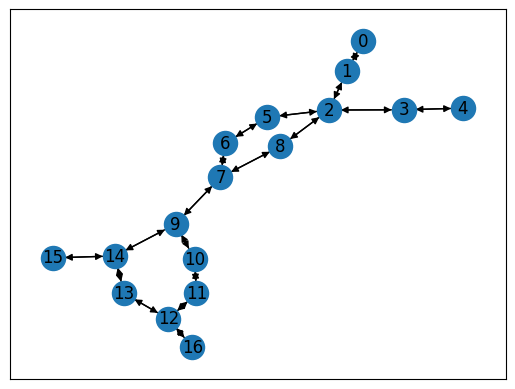

In [10]:
visualize_graph(train_dataset[i])

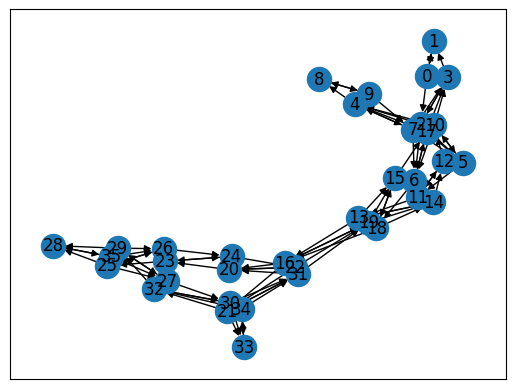

In [11]:
visualize_graph(train_dataset_lg[i], line_graph=True)

Trying adding an isolated node to it and converting to line-graph

In [12]:
transform = LineGraphTransform(bring_in_adjacent_nodes=True, keep_as_is=['fingerprint', 'molecule_descriptor', 'y'], self_loop_strategy='isolated_nodes_only')

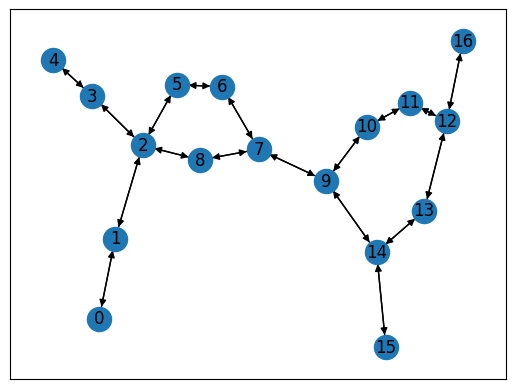

In [13]:
g = train_dataset[i]
visualize_graph(g)

In [14]:
g.x = torch.cat((g.x, torch.ones((1,9))), dim=0)
g.positions_3d = torch.cat((g.positions_3d, torch.ones((1,3))), dim=0)

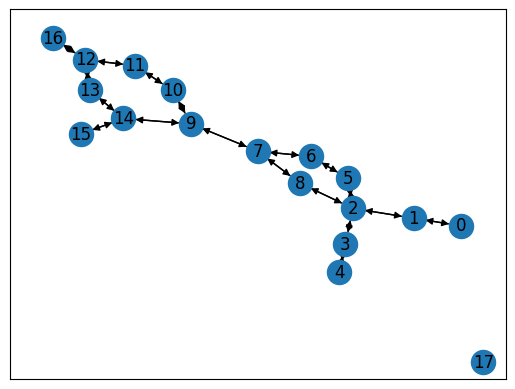

In [15]:
visualize_graph(g)

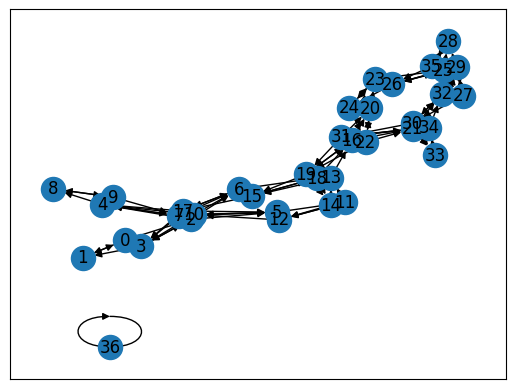

In [16]:
visualize_graph(transform(g), line_graph=True)